尝试研究下网格交易。

根据历史数据估计一段时间内的涨跌幅，这个涨跌幅的随机变量的95%分位数作为网格的最大目标价。

网格算法的实现是：
* 以入场价买入50%仓位，在入场价上下各设置5个网格，上下网格等间距
* 从上到下，每个网格的目标仓位为0%， 10%， 20%， 30%，40%， 50%， 60%， 70%， 80%， 90%， 100%，
  到达目标网格后，调整仓位到相应的仓位
* 假设对涨跌幅分布的预测是靠谱的情况下，则有很小的概率股价会游离到网格之外，即高于最高网格价p_h或者低于最低网格价p_l。
  这种情况下，就对网格进行调整，分别以p_h或者p_l作为新网格的入场价格。 由于每一次对网格的调整涉及到重新
  预测未来的涨跌幅的分布，这需要相应频率的历史数据的支持，在交易时间段，这个数据是不好获取的（假设预期的
  网格周期个周，那么做涨跌幅分布的估计就需要周的数据， 如果这个周不限制是严格的周一到周五的区间时，只要在任意
  交易日的收盘都是可以获取到最新的周回报数据的，但是这个数据在交易时间段是获取不到的，或者说即使能够获取到，
  这个数据也是有延迟的。）
* 网格的调整发生在开盘的时刻（因为网格的调整依赖对一定周期内的涨跌幅的分布的估计，而这个周期通常都是日频的倍数，
  这里的一定周期也称作网格周期，表示网格大概率能够持续的时间，网格持续的时间越久，就能够有更多的机会获取回报，
  网格的持续时间更网格大小成正比，网格越大，持续时间越久，但是网格越大，价格穿过网格的次数就越少，小的波动就捕捉不到。
  ），


关于网格大小

网格大小由网格的个数与间隔决定，网格个数越多，则网格越大，网格持续时间越长，但是每个网格获得的收益降低。关于
个数的设置没有好的研究办法，先不做研究。 当网格个数固定的情况下，网格间隔越大，则网格的持续时间更长，每次穿过
网格的收益也越高，但是相同时间跨度内穿过网格的次数更少了，所以间隔是在持续时间与穿过次数之间的权衡（之所以
希望网格的持续时间越长越好，是因为网格切换是要付出成本的，向下的网格切换是在更低的价格卖出一定的仓位，要承担
一定的损失， 向上的网格切换会让整体的持仓成本变高，虽然本次网格能够带来一点利润，但持仓成本变高不是什么好事）。
所以我们的目标是保证一定交易频率（交易次数/2 乘以单操作利润 是总利润）的基础上让网格的持续时间足够长。
或者说保证持续时间的基础上让交易利润足够高，由于股价是不可预测的，我们只能基于统计数据在一定置信度上保证
持续时间（比如以95%的自信度保证网格的持续时间为一周）。确定了持续时间后，通常网格的最高价格和最低价格就
确定了。 剩下的就是确定网格大小了。 记得波动率交易这本书里面有一种衡量波动率的方法，就是价格变动固定单位
的所需要的时间，这个时间的统计值可以用于衡量波动率，如果t较小，则波动率较高，如果t较高，则波动率较低。
假设我们通过统计方法找到了价格变动值跟t的期望值之间的一个函数关系，就能够将总利润转化为网格大小的一个函数，
如果这个函数是一个凸函数的话，则很容易找到最优的网格大小。

这个方法里面，最难的在于找到网格大小与变动该网格大小所需要的时间的期望值之间的关系，并对这个关系建立模型

In [1]:
from se2.domain.time_series import *
from se2.domain.engine import *
from se2.domain.account import *
from se2.domain.common import *
import pandas as pd
import numpy as np
import scipy.stats


ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:usfarm.nj
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:usfarm.nj
ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:hfarm
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:hfarm
ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:cashfarm
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:cashfarm
ERROR:ibapi.wrapper:ERROR -1 2104 市场数据农场连接正常:usfarm
ERROR:root:ib client error, req_id:-1, errorCode:2104, errorString:市场数据农场连接正常:usfarm
ERROR:ibapi.wrapper:ERROR -1 2106 历史市场数据农场连接正常:hkhmds
ERROR:root:ib client error, req_id:-1, errorCode:2106, errorString:历史市场数据农场连接正常:hkhmds
ERROR:ibapi.wrapper:ERROR -1 2106 历史市场数据农场连接正常:ushmds
ERROR:root:ib client error, req_id:-1, errorCode:2106, errorString:历史市场数据农场连接正常:ushmds
ERROR:ibapi.wrapper:ERROR -1 2158 Sec-def数据农场连接正常:secdefhk
ERROR:root:ib client error, req_id:-1, errorCode:2158, errorString:Sec-def数据农场连接正常:secdefhk


In [75]:
code = 'SPCE_STK_USD_SMART'
start = pd.Timestamp('2021-01-09 21:00:00', tz='Asia/Shanghai')
end = pd.Timestamp('2021-06-09 21:00:00', tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, [code])
ts_repo: TimeSeriesRepo = BeanContainer.getBean(TimeSeriesRepo)
ts: TimeSeries = ts_repo.find_one("ibMinBar")
MIN_BAR_DF: DataFrame = ts.history_data(command, from_local=True)
MIN_BAR_DF = MIN_BAR_DF.droplevel(level=1)
MIN_BAR_DF.head()

,start_time,open,high,low,close,volume
visible_time,,,,,,
2021-01-11 22:31:00+08:00,2021-01-11 22:30:00+08:00,24.97,24.99,24.85,24.86,2193
2021-01-11 22:32:00+08:00,2021-01-11 22:31:00+08:00,24.85,25.14,24.81,25.06,484
2021-01-11 22:33:00+08:00,2021-01-11 22:32:00+08:00,25.09,25.17,24.85,24.91,539
2021-01-11 22:34:00+08:00,2021-01-11 22:33:00+08:00,24.97,25.00,24.80,24.85,691
2021-01-11 22:35:00+08:00,2021-01-11 22:34:00+08:00,24.83,24.96,24.77,24.79,359


In [12]:
# 找到价格变动幅度与变动所需要的时间的关系
Y = 0.01
times = []
t = 0
start_price = None
high = None
low = None
for _,min_bar in MIN_BAR_DF.iterrows():
    if not start_price:
        start_price = min_bar['close']
        continue
    t += 1
    if not high:
        high = min_bar['high']
    else:
        high = max(min_bar['high'], high)

    if not low:
        low = min_bar['low']
    else:
        low = min(min_bar['low'], low)

    if np.log(high/start_price) > Y or abs(np.log(low/start_price)) > Y:
        times.append(t)
        t = 0
        start_price = min_bar['close']
        high = None
        low = None
print('done')

done


In [ ]:
# 从上面可以看出， 波动率的变化是非常频繁的，这主要是收到开盘和收盘波动率较高以及开盘跳空的影响导致的
# 且由于收盘之后没有价格数据，所以其波动率是无法观测到的，也就无法观测到退出时间（变化特定幅度所需要的时间）

In [ ]:
# 我们的目标是估计特定时间周期内的交易次数，这相当于是波动率领域里面的整合波动率，不需要考察波动率的微观结构
# 由于日间收益的样本数很少，所以估计日间收益带来的交易次数是有很多的估计误差的，所以一个好的方法是使用
# 较长的一段历史时间区间内的日间收益计算出来日间收益的交易次数的平均值，而不是使用最近的最近的几个日间
# 收益的样本值来进行预测。
#


In [85]:
P = 5
Y = 0.04

def calc_intra_daily_trade_count(daily_df: DataFrame):
    if len(daily_df) <= 0:
        return None
    start_price = None
    high = None
    low = None
    c = 0
    for _,min_bar in daily_df.iterrows():
        if not start_price:
            start_price = min_bar['open']
        if not high:
            high = min_bar['high']
        else:
            high = max(min_bar['high'], high)

        if not low:
            low = min_bar['low']
        else:
            low = min(min_bar['low'], low)
        if np.log(high/start_price) > Y or abs(np.log(low/start_price)) > Y:
            c += 1
            start_price = min_bar['close']
            high = None
            low = None
    return c

INTRA_DAY_TRADE_COUNT = MIN_BAR_DF.groupby(pd.Grouper(freq='1D',
                              origin=pd.Timestamp("21:00:00", tz='Asia/Shanghai'))).apply(calc_intra_daily_trade_count).dropna()
INTRA_DAY_TRADE_COUNT


visible_time
2021-01-11 21:00:00+08:00    0.0
2021-01-12 21:00:00+08:00    1.0
2021-01-13 21:00:00+08:00    1.0
2021-01-14 21:00:00+08:00    5.0
2021-01-15 21:00:00+08:00    1.0
                            ... 
2021-06-02 21:00:00+08:00    4.0
2021-06-03 21:00:00+08:00    4.0
2021-06-04 21:00:00+08:00    0.0
2021-06-07 21:00:00+08:00    2.0
2021-06-08 21:00:00+08:00    3.0
Length: 103, dtype: float64

In [86]:
# 下面计算日间收益带来的交易次数，交易次数为日间收益的绝对值跟阀值的比值
inter_day_rets = np.log(MIN_BAR_DF['open']/ MIN_BAR_DF['close'].shift(1)).\
                    groupby(pd.Grouper(freq='1D',
                       origin=pd.Timestamp("21:00:00", tz='Asia/Shanghai'))).head(1).dropna()
INTER_DAY_TRADE_COUNT = (inter_day_rets.abs()/Y).astype(int)
INTER_DAY_TRADE_COUNT


visible_time
2021-01-12 22:31:00+08:00    0
2021-01-13 22:31:00+08:00    0
2021-01-14 22:31:00+08:00    3
2021-01-15 22:31:00+08:00    0
2021-01-19 22:31:00+08:00    1
                            ..
2021-06-02 21:31:00+08:00    0
2021-06-03 21:31:00+08:00    0
2021-06-04 21:31:00+08:00    0
2021-06-07 21:31:00+08:00    0
2021-06-08 21:31:00+08:00    0
Length: 102, dtype: int64

In [92]:
# 统计交易次数跟网格间隔之间的函数关系
# 假设日间交易次数跟日内交易次数是成正比的，且这个比例系数是是关于间隔的函数

def get_intra_day_trade_counts(df: DataFrame, X):
    def calc_intra_daily_trade_count(daily_df: DataFrame):
        if len(daily_df) <= 0:
            return None
        start_price = None
        high = None
        low = None
        c = 0
        for _,min_bar in daily_df.iterrows():
            if not start_price:
                start_price = min_bar['open']
            if not high:
                high = min_bar['high']
            else:
                high = max(min_bar['high'], high)

            if not low:
                low = min_bar['low']
            else:
                low = min(min_bar['low'], low)
            if np.log(high/start_price) > X or abs(np.log(low/start_price)) > X:
                c += 1
                start_price = min_bar['close']
                high = None
                low = None
        return c

    return df.groupby(pd.Grouper(freq='1D',
                              origin=pd.Timestamp("21:00:00", tz='Asia/Shanghai'))).apply(calc_intra_daily_trade_count).dropna()

def get_inter_day_trade_counts(df: DataFrame, X):
    inter_day_rets = np.log(df['open']/ df['close'].shift(1)).\
                    groupby(pd.Grouper(freq='1D',
                       origin=pd.Timestamp("21:00:00", tz='Asia/Shanghai'))).head(1).dropna()
    return (inter_day_rets.abs()/X).astype(int)

start = pd.Timestamp('2020-06-25 21:00:00', tz='Asia/Shanghai')
end = pd.Timestamp('2021-06-25 21:00:00', tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, [code])
ts_repo: TimeSeriesRepo = BeanContainer.getBean(TimeSeriesRepo)
ts: TimeSeries = ts_repo.find_one("ibMinBar")
MIN_BAR_DF: DataFrame = ts.history_data(command, from_local=True)
MIN_BAR_DF = MIN_BAR_DF.droplevel(level=1)

In [95]:
# 使用最近一年的数据来找到网格间隔跟比例之间的关系
X = [0.01*(i+1) for i in range(10)]
percents = []
for x in X:
    c1 = get_intra_day_trade_counts(MIN_BAR_DF, x).mean()
    c2 = get_inter_day_trade_counts(MIN_BAR_DF, x).mean()
    # print("c1:{}, c2:{}".format(c1, c2))
    percents.append(c1 / c2)
percents

[12.624026576531795,
 8.882138766159384,
 7.765179534597009,
 6.303245676380005,
 5.716356107660456,
 5.976190476190476,
 5.83390022675737,
 4.924823633156967,
 5.561177248677248,
 4.53747795414462]

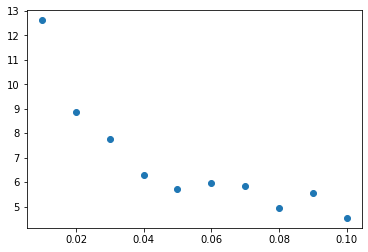

In [97]:
import matplotlib.pyplot as plt
plt.scatter(X, percents)

In [91]:
MIN_BAR_DF

,start_time,open,high,low,close,volume
visible_time,,,,,,
2020-06-25 21:31:00+08:00,2020-06-25 21:30:00+08:00,15.70,15.75,15.55,15.65,1722
2020-06-25 21:32:00+08:00,2020-06-25 21:31:00+08:00,15.64,15.66,15.58,15.61,431
2020-06-25 21:33:00+08:00,2020-06-25 21:32:00+08:00,15.59,15.70,15.56,15.70,441
2020-06-25 21:34:00+08:00,2020-06-25 21:33:00+08:00,15.68,15.82,15.65,15.73,669
2020-06-25 21:35:00+08:00,2020-06-25 21:34:00+08:00,15.73,15.78,15.68,15.77,359
...,...,...,...,...,...,...
2021-06-25 03:56:00+08:00,2021-06-25 03:55:00+08:00,40.37,40.40,40.37,40.38,315
2021-06-25 03:57:00+08:00,2021-06-25 03:56:00+08:00,40.37,40.37,40.22,40.27,336
2021-06-25 03:58:00+08:00,2021-06-25 03:57:00+08:00,40.27,40.33,40.24,40.32,400


In [46]:
# 下面统计一段时间区间内波动率锥（收盘价-收盘价），基于波动率锥可以得到波动率的95%置信区间，
# 这个置信区间的上界作为网格大小
P = 5
def calc_ret(s: Series):
    return np.log(s[-1]/s[0])
df:DataFrame = MIN_BAR_DF.groupby(pd.Grouper(freq='1D', origin=pd.Timestamp("21:00:00", tz='Asia/Shanghai'))).tail(1)
rets = df['close'].rolling(window=P).apply(calc_ret).dropna()
rets

visible_time
2021-05-15 04:00:00+08:00   -0.104928
2021-05-18 04:00:00+08:00   -0.085808
2021-05-19 04:00:00+08:00    0.070236
2021-05-20 04:00:00+08:00    0.107552
2021-05-21 04:00:00+08:00    0.202411
2021-05-22 04:00:00+08:00    0.235692
2021-05-25 04:00:00+08:00    0.444686
2021-05-26 04:00:00+08:00    0.393810
2021-05-27 04:00:00+08:00    0.309280
2021-05-28 04:00:00+08:00    0.390950
2021-05-29 04:00:00+08:00    0.147920
2021-06-02 04:00:00+08:00    0.123023
2021-06-03 04:00:00+08:00    0.142063
2021-06-04 04:00:00+08:00   -0.002574
2021-06-05 04:00:00+08:00    0.007027
2021-06-08 04:00:00+08:00    0.179784
2021-06-09 04:00:00+08:00    0.188144
Name: close, dtype: float64

In [68]:
# 对总体方差的无偏估计为

var = np.power(rets, 2).sum() / (len(rets))

# 对总体波动率的无偏估计为
b = 1
s = np.sqrt(var) / b

# 对方差的方差的估计值为
var_of_var = np.power(np.power(rets, 2) - np.power(rets,2).mean(), 2).sum() / len(rets)

# 由于使用了重叠数据，所以这个var_or_var被显著的低估了
var_of_var_adj = var_of_var * (1 / (1 - P/len(rets) + (P*P - 1)/(3*len(rets)*len(rets))))

# 所以波动率的95%置信区间为
[s-1.96*np.sqrt(var_of_var_adj), s + 1.96*np.sqrt(var_of_var_adj)]


[0.08623945498516741, 0.27577718039535826]

In [67]:
# 从上面的结果来看，要时网格能够在95%的置信度上持续P天的话，网格大小是非常大的
# 如果使用过去一个月的估计数据的话，这个网格跨度为74个点，如果使用2个月的数据进行估计的话，跨度为54个点
